# This workbook contains unfinished and unpolished implementations of a Kalman Filter for the purpose of solving time-varing Vector Autoregression problems, i.e. obtaining time-varying VAR coefficients between any number of simultaneously measured time-series. Feel free to use this as material for reference or as a base for your own implementation. 

# NB: Much of the code here has a varying level of quality and scalability. Also please refer to the literature mentioned in comments, clarified more precisely in my blogpost on the subject. 

### General Kalman-Filter based VAR model. Works for any m-dimensions, but could use some more cleanup and in general formula checking.

Data should be provided in a pandas Dataframe in the form of _rows = dimensions/time-series_ and _columns = time-indexes_, with syntax:

    kalman_var(data_in, order, lamda = 0.5)

The _lamda_ is $\lambda$ and added by Havlicek2010, should understand its purpose better. Its in general a smoothing parameter that has seemed useful in my exploration of the formulas. Cant exactly explain how though. Something to do with exponential smoothing in general. 

The code outputs 5 data structures, not all of which are actually important, but left for diagnostic purposes. The outputs are:

    Yhat, Xhatstorage, Errorstorage, Rstorage, Pstorage

From first to last: the predictions of time-series from Kalman VAR, the residuals of the prediction, the covariance matrixes of each prediction process, the noise covatiance matrixes. 

In [32]:
def kalman_var(data_in, order, lamda = 0.03): #The lambda parameter is set to 0.03 by default, since that is what many use, citing efficiency (see Milde 2010)

    import numpy as np
    
    data = data_in.values #making the data into a numpy array for comfortable manipulation
    lam = lamda #Lambda is a sort of adaptation constant, governing the change of measurement noize, which in our-case is pseudonoise of the TS process itself
    p = order #VAR model order
    
    m = data.shape[0] #Checking how many rows in data input = dimensions or number of time-series
    sL = data.shape[1] #Checking length of time-series, "sL" as in series-length
        
    F = np.identity((m**2)*p) #F is the transition matrix, when it is a unit matrix it indicates that the coefficients evolve as a random walk. 
    Xhatminus = [1/m]*(m**2)*p #To make handlind outputs similar to inputs, we fill the coefficient matrixes with zeros up to t=p, since there is the first prediction for the state
    Q = np.identity((m**2)*p)*(10**(-3)) #Q is the state process noise covariance matrix. The states evolve independently, so unity matrix. Multiplied by a small number to indicate some noize in their initial evolution
    E = np.array([0.5]*m) #Just initializing the error holder or in fact, the measurement process noize values. This is not used and calculated later as series_value - predicted_value 
    R = np.dot(data_in.iloc[:,0:10],data_in.iloc[:,0:10].transpose()) #Initializing covariance of data noize through data itself, values up to 10. Should then start analysis from 10th time point, but for testing its ok. 
    Pmin = np.identity((m**2)*p)  #The initial one step ahead prediction of the state covariance. 
    Yhat = np.zeros((m,(sL))) #Creating a prediction array, that will contain predicted values based on the state estimates

    Errorstorage = [[0]*m]*p
    Xhatstorage = [[1]*(m**2)*p]*p
    Rstorage = [np.eye(m)]*p #[[[1, 1],[1, 1]]]*p
    Pstorage = [np.identity((m**2)*p)]*p

    for i in range(p,sL): #This is the Kalman VAR reccursion, based on Havlicek 2010 and Schlögl 2000 (specifically the adaption criteria lambda etc)

        Y = data[:,range((i-p),i+1)] #Partitioning necessary data for p-length loop, including next one for update and prediction comparison.
        H = np.kron( np.identity(m) , Y[:, range(0,p)].transpose().flatten() )
        K = np.dot( np.dot(Pmin, H.transpose()) , np.linalg.inv( np.dot( np.dot( H, Pmin ), H.transpose() ) + R ) ) #Calculating the Kalman Gain
        Xhatplus = np.dot(F , ( Xhatminus + np.dot(K , (Y[:, p] - np.dot(H, Xhatminus) )) ) ) #Calculating new coefficients
        E = Y[:,p] - np.dot(H, Xhatminus) #Calculating error from estimate and actual time-series noise
        Errorstorage.append(E)
        R2 = (1-lam)*R + (lam*( np.dot([[item] for item in E],[E]) )) #Here updating the measurement noise covariance R, MIGHT have to be unit matrix multiplied for independance...
        R = R2
        P = Pmin - np.dot( np.dot(K , H) , Pmin ) #Calculating the estimate error covariance - this is essentially the estimate of the error from the REAL coefficients, we are trying to find - separate from state evolution noise. 
        #Havlicek2010 uses a different order and notation: P = (np.identity((m**2)*p) - (np.dot(K , H)))*Pmin, ends up the same. 
        Q = ( np.identity((m**2)*p) * lam * (np.trace(P)) )/(p*sL) #The division by (p*sL) is a bit suspect. Havlicek 2010 uses this, but Schlöhl 2000 does not suggest it. Might be interpretation issue and actually be the same. 
        Pplus = ( np.dot( np.dot(F, P) , F) ) + Q #Updating the estimate error covariance
        Xhatstorage.append(Xhatplus) #storing loop values, moving on after that
        Rstorage.append(R)
        Xhatminus = Xhatplus
        Pmin = Pplus
        Pstorage.append(Pplus)

        for h in range(0,m):
            Yhat[h,i] = np.dot(H[h], Xhatplus)

    return Yhat, Xhatstorage, Errorstorage, Rstorage, Pstorage

### Generalized GPDC calculation algorithm. Works for any m-dimensions, taking input from the General Kalman-Filter based VAR model. 

The code takes in the _Xhatstorage_ matrix, the _Rstorage_ matrix, the model-order and freqiencies, at which to calculate GPDC: The frequencies are normalized frequencies, taking values from $-0.5$ to $0.5$, should be given as an array of values (i.e. [-0.5, -0.4, ... 0.4, 0.5] ). The implication and translation of this needs more reading from me. For cases where freqeuency itself its not of direct interest, median GPDC is a powerful metric of Granger causality still (seen also in Havlicek _et al_, 2010 and others)

The syntax is: 

    calcGPDC(Xhatstorage, Rstorage, order, frequencies)
    
The code gives 2 outputs: 

    MasterAdic, f_list
    
The first is a dictionary of dataframes with the calculated GPDC in each direction (dictionary keys) and for each time-step. The keys are in the form of strings, as "A11", "A12", ..., "A1m", "A21", "A22", ... "A2m", ..., "Amm", where m is the number of time-series, the dimensionality. 
The f_list is also the input frequencies.

In [2]:
def calcGPDC(Xhatstorage, Rstorage, order, frequencies, m_in): #New-generalized version!
    #f_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    f_list = frequencies
    nf=len(f_list)
    p = order
    sL = len(Xhatstorage)
    m = m_in#int(len(Xhatstorage[sL-2])/(2*p)) #at loc sL-2 because ... random.. just wanted to be sure its beyond any order p I test, otherwise might be the filler and wrong.
    
    
    unit=p*m
    tab = np.zeros([m, m], dtype=object)
    for i in range(1,m+1):
        for j in range(1,m+1):
            temp_tab = []
            for add in range(0,p):
                temp_tab.append(
                    ((unit*(i-1))+(j-1))+(m*add)
                )
            tab[j-1,i-1] = temp_tab
    
    holder = []

    import itertools
    for u in range(0,nf):

        f = f_list[u]

        for z in range(0,p):
            holder.append(np.zeros(shape=(m,m)))

        for t in range(p,sL):

            calc1=0
            for r in range(0,p):
                calc1 += np.array(
                    [ [ Xhatstorage[t][tab[i,j][r]] for i in np.arange(0,m) ] for j in np.arange(0,m)]
                    ) * np.exp( np.pi * 2 * f * 1j * (p-r) )  #Generalized frequency domain coefficient tab creation!

            holder.append(np.identity(m) - calc1)

    combinations = list(itertools.product( np.arange(1,m+1),np.arange(1,m+1)))

    Adic = {} #Creating a dictionary of directional dataframes. A12 would be causality from track 2 to 1. General to  three-way and n-way GPDC 
    for combo in combinations:
        key = f'A{combo[0]}{combo[1]}' 
        value = pd.DataFrame( np.zeros([sL,nf]), columns = ["f = " + str(round(item,4)) for item in f_list] )
        Adic[key] = value



    combo_names = [key for key in Adic]
    #print(combo_names)
    
    for u in range(0,nf):
        #Here basically i just segment the relevant coefficient matrixes based on n-th frequency from Holder list (its just sL of coefficients stacked ontop of eachother, so 5*sL and i separate them)
        mitmes = u
        x=int((len(holder)/nf)*mitmes)
        y=int((len(holder)/nf)*(mitmes+1)+1)
        temp_hold = holder[x:y-1]
        #print(temp_hold[10:20])
        for t in range(0,sL): #Perhaps start from 0, but maybe from 10% of sL
            
            GPDCtab = [ [ (
                (abs( ( temp_hold[t][j,i]*(1/Rstorage[t][j][j]) ) /
                     np.sqrt( sum( [ (abs(temp_hold[t][g,i])**2) * (1/(Rstorage[t][g][g]**2)) for g in np.arange(0,m) ] )
                         ) ))**2
            ) for i in np.arange(0,m)] for j in np.arange(0,m)] #This is the absolute GPDC^2 formula generalized for any m dimensions. See Baccala et al 2007



        #The function is of the form: 
        # (1/sigma(i))A(i,j,f)
        #-------------------- <- division line
        # Sqrt( Sum_k( (1/sigma(k)^2) A(k,j)^2 ) )
        #
        #::: sigma is the variance, contained inside of Rstorage matrix. 

            norm_tab = [ sum([ GPDCtab[i][j] for i in np.arange(0,m) ]) for j in np.arange(0,m) ]

            for name in combo_names: #names are in order of 11, 12, 1..., 21, 22, 2..., mm
                row = int(name[1])-1 #converting name indexer to usable float
                col = int(name[2])-1
                Adic[name].iloc[t,u] = GPDCtab[row][col]/norm_tab[col] #Normalizing as in Baccala et al 2007 (GPDC creators)
   
        #Normalizing in the form:
        #Sum_i abs( GPDC(i,j) )^2 == 1
        #
        #So each value in column j is divided by this sum. 
    
    MasterAdic = {} #Creating a dictionary of directional dataframes, filtered for NaN values

    for key in Adic:
        data_to_work = Adic[key]
        is_NaN = data_to_work.isnull()
        row_has_NaN = is_NaN.any(axis=1)
        rows_with_NaN = data_to_work[row_has_NaN]
        rows_to_drop=rows_with_NaN.index
        data_to_work.drop(data_to_work.index[rows_to_drop])
        data_to_work = data_to_work.drop(data_to_work.index[rows_to_drop])
        data_to_work = data_to_work.reset_index().drop("index", axis=1)
        MasterAdic[key] = data_to_work
    
    
    return MasterAdic, f_list

### Generalized bootstrapping algorithm below, works for any m-dimensional VAR model coefficients, generated by the latter.

The code bootstraps null-hypothesis time-series and calculates the GPDC for each such time-series at each time-step. The null-hypothesis of the time-series is zero connectivity, for which we evaluate the GPDC by first reconstructing all time-series _based on_ only their _own_ VAR coefficients, found in the Kalman VAR model. These can then be used to filter out the full-models GPDC signals for spurious ones.  

The algorithm takes as inputs the original dataframe, the length of the bootstrap (should be rather high for a decent build of the empirical distribution for null-hypothesis), the Xhatstorage, the Errorstorage, the model-order and the frequency list. Syntax:

    bootstrap_freqDist(data_in, boostratp_len_in, Xhatstorage_in, Errorstorage_in, order, f_list)

The algorithm outputs one dictionary, _Fdic_. This contains the same keys as MasterAdic, inside of which the median GPDC over time-steps, for all drection of influence. Since these estimates are based off of time-series, reconstructed with their own coefficients and a resampled error, the GPDC values are used to build a null-hypothesis distribution for _no connectivity_. The 90th precentile is easy to find from such a list, for _each frequency_ and filter it out from the full models GPDC.  


In [3]:
def bootstrap_freqDist(data_in, boostratp_len_in, Xhatstorage_in, Errorstorage_in, order, f_list, m_in): #GENERALIZED to work witn any m-dimensions like other code pieces
    
    data = data_in
    p = order
    Xhatstorage = Xhatstorage_in
    Errorstorage = Errorstorage_in
    
    sL = len(Xhatstorage)
    m = m_in #at sL-p since it should always exist as index and im afraid the beginning part might flunk, sometimes filled by loop over p

    num_freq = len(f_list)
    bootstrap_len = int(boostratp_len_in)
    
    import itertools
    combinations = list(itertools.product( np.arange(1,m+1),np.arange(1,m+1)))

    Fdic = {} #Creating a dictionary of dataframes, holding median bootstrap values of GPDC in all directions for all frequencies. 
    for combo in combinations:
        key = f'A{combo[0]}{combo[1]}'  #Keys should be the same as in the GPDC dictionary for conveneince in code. 
        value = pd.DataFrame( np.ones([bootstrap_len,num_freq]), columns = ["f = " + str(round(item,4)) for item in f_list] )
        Fdic[key] = value

    unit=p*m
    tab = np.zeros([m, m], dtype=object)
    for i in range(1,m+1):
        for j in range(1,m+1):
            temp_tab = []
            for add in range(0,p):
                temp_tab.append(
                    ((unit*(i-1))+(j-1))+(m*add)
                )
            tab[j-1,i-1] = temp_tab

    for o in range(0, bootstrap_len):

        dummy = o

        #Creating error resample dataframe
        
        error_df = pd.DataFrame([item[0] for item in Errorstorage[ int((sL/100)*10) :]]) #Starting with the first time-series as first resample, since there has to be atleast two anyway. Generalize in next step
        
        for dim in range(1,m):
            error_df[dim] = [item[dim] for item in Errorstorage[ int((sL/100)*10) :]]
        
        #Resampling errors:
        
        error_resamp_df = pd.DataFrame( np.random.choice(error_df.iloc[:,0], sL, replace=True) )
        for dim in range(1,m):
            error_resamp_df[dim] = np.random.choice(error_df.iloc[:,dim], sL, replace=True)
        error_resamp_df = error_resamp_df.transpose()
        
        #Creating Data resample holder as dictionary of dimensions and lists to append to in loop:
        resamp_dic = {}
        
        for dim in range(0,m):
            resamp_dic[dim] = [0]*p

        #Classical VAR build of the prediction, resampled error added. 
        for i in range(p,sL): #Only calculating the prediction based on time-series own coefficients for resampling of null-hypothesis
            for to_series in range(0,m): #Diagonal elements of coefficient matrixes are to own direction
                predict = np.dot( Xhatstorage[i][ tab[ to_series ][ to_series ] ] , data.iloc[to_series,i-p:i] )  + error_resamp_df.iloc[ to_series, i ]
                resamp_dic[ to_series ].append( predict )

        data_resamp = pd.DataFrame( resamp_dic ).transpose()


        Yhat_resamp, Xhatstorage_resamp, Errorstorage_resamp, Rstorage_resamp, Pstorage = kalman_var(data_resamp.iloc[:, int((sL/100)*10): ], p) 
    
        MasterAdic, f_list = calcGPDC(Xhatstorage_resamp, Rstorage_resamp, p, f_list, m) 
       
        for key in Fdic:
            for i in range(0, num_freq):
                Fdic[key].iloc[o,i] = MasterAdic[key].iloc[:,i].median()
        
    return Fdic 

### Normalized Direct/Causality metric calculation (from Oya2007)

Might need some tweaking, since it is really long and slow, but shouldnt really be. The inputs are:

* coefficient matrix, made by Kalman algorithm
* FROM_WHICH_CHANNEL as a number
* TO_WHICH_CHANNEL as a number
* order of model that generated coefficients (can make automatic, but so far am sloppy with it)
* dimensionality of data that was used in Kalman to generate the coefficients (same as above)



In [3]:
def norm_dc(coef_matrix_list_in, from_where, to_where, p_in, m_in):
    #Calculates the normalized direct-causality, from Oya, et al. 2007, by Ding, et al. 2001
    coef_matrix_list_in = coef_matrix_list_in
    
    p = p_in
    m = m_in
    from_where = from_where
    to_where = to_where
    
    import numpy as np
    unit=p*m
    tab = np.zeros([m, m], dtype=object)
    for i in range(1,m+1):
        for j in range(1,m+1):
            temp_tab = []
            for add in range(0,p):
                temp_tab.append(
                    ((unit*(i-1))+(j-1))+(m*add)
                )
            tab[j-1,i-1] = temp_tab # COLUMNS means TO WHERE, row means FROM WHERE 
    
    coefs_to_use = tab[from_where][to_where]
    coefs_to_get = []
    for coef_i in coefs_to_use:
        coefs_to_get.append(coef_matrix_list_in[coef_i])
    from_to_one = np.sum(np.abs(np.array(coefs_to_get)))
    
    coefs_to_use = np.array([item for item in tab[:][from_where]]).flatten()
    coefs_to_get = []
    for coef_i in coefs_to_use:
        coefs_to_get.append(coef_matrix_list_in[coef_i])
    from_to_all = np.sum(np.abs(np.array(coefs_to_get)))
    
    norm_dc_output = from_to_one/from_to_all
    dc_output = from_to_one
    
    return norm_dc_output, dc_output

### Bootstrapping algorithm for any of my Kalmans

It can take input of lambda memory coefficient and does a smoothed estimate for bootstrap coefficients. 

In [4]:
def bootstrap_ndc_2(data_in, boostratp_len_in, Xhatstorage_in, Errorstorage_in, order, m_in, lamda = 0.0001): #MEANT TO WORK FOR PAIR DATA
    
    lam = lamda
    data = data_in
    p = order
    Xhatstorage = Xhatstorage_in
    Errorstorage = Errorstorage_in
    
    sL = len(Xhatstorage)
    m = m_in #at sL-p since it should always exist as index and im afraid the beginning part might flunk, sometimes filled by loop over p

    bootstrap_len = int(boostratp_len_in)
    
    import itertools
    combinations = list(itertools.product( np.arange(1,m+1),np.arange(1,m+1)))

    unit=p*m
    tab = np.zeros([m, m], dtype=object)
    for i in range(1,m+1):
        for j in range(1,m+1):
            temp_tab = []
            for add in range(0,p):
                temp_tab.append(
                    ((unit*(i-1))+(j-1))+(m*add)
                )
            tab[j-1,i-1] = temp_tab
    
    ndc_dic = {}
    
    for o in range(0, bootstrap_len):
        
        dummy = o
        
        try:
            #Creating error resample dataframe

            error_df = pd.DataFrame([item[0] for item in Errorstorage[ int((sL/100)*10) :]]) #Starting with the first time-series as first resample, since there has to be atleast two anyway. Generalize in next step

            for dim in range(1,m):
                error_df[dim] = [item[dim] for item in Errorstorage[ int((sL/100)*10) :]]

            #Resampling errors:

            error_resamp_df = pd.DataFrame( np.random.choice(error_df.iloc[:,0], sL, replace=True) )
            for dim in range(1,m):
                error_resamp_df[dim] = np.random.choice(error_df.iloc[:,dim], sL, replace=True)
            error_resamp_df = error_resamp_df.transpose()

            del error_df

            #Creating Data resample holder as dictionary of dimensions and lists to append to in loop:
            resamp_dic = {}

            for dim in range(0,m):
                resamp_dic[dim] = [0]*p

            #Classical VAR build of the prediction, resampled error added. 
            for i in range(p,sL): #Only calculating the prediction based on time-series own coefficients for resampling of null-hypothesis
                for to_series in range(0,m): #Diagonal elements of coefficient matrixes are to own direction
                    predict = np.dot( Xhatstorage[i][ tab[ to_series ][ to_series ] ] , data.iloc[to_series,i-p:i] )  + error_resamp_df.iloc[ to_series, i ]
                    resamp_dic[ to_series ].append( predict )

            del error_resamp_df

            data_resamp = pd.DataFrame( resamp_dic ).transpose()
            data_resamp_2 = data_resamp.T
            data_resamp_2 = data_resamp_2.iloc[::-1].reset_index().drop("index",axis=1)
            data_resamp_3 = pd.concat([data_resamp.T,data_resamp_2]).reset_index().drop("index",axis=1) #to do reverse kalman too. 

            del resamp_dic        
            del data_resamp
            del data_resamp_2
            
            Yhat_resamp, Xhatstorage_resamp, Errorstorage_resamp, Rstorage_resamp, Pstorage = kalman_var(data_resamp_3.T, p, lam) 
            
            del Yhat_resamp
            del Errorstorage_resamp
            del Rstorage_resamp

            ####################################
            ########## KALMAN SMOOTHER #########
            ####################################

            Xhat_to_reverse = Xhatstorage_resamp[int(len(Xhatstorage_resamp)/2):int(len(Xhatstorage_resamp))]
            Xhat_reversed = Xhat_to_reverse[::-1]

            Pstorage_to_reverse = Pstorage[int(len(Xhatstorage_resamp)/2):int(len(Xhatstorage_resamp))]
            Pstorage_reversed = Pstorage_to_reverse[::-1]

            Xhatstorage_smooth = []

            for i in range(0,int(len(Xhatstorage_resamp)/2)):
                Xhatstorage_smooth.append(
                    np.dot( np.linalg.inv( np.linalg.inv(Pstorage[i]) + np.linalg.inv(Pstorage_reversed[i]) ) , 
                      ( np.dot( np.linalg.inv(Pstorage[i]) , Xhatstorage_resamp[i]) + np.dot(np.linalg.inv( Pstorage_reversed[i] ) , Xhat_reversed[i]) ) 
                      )
                )

            del Pstorage
            del Pstorage_to_reverse
            del Pstorage_reversed
            del Xhat_to_reverse
            del Xhatstorage_resamp
            del Xhat_reversed

            holder = []
            direction_list = []
            for l in range(m):
                for j in range(m):
                    if j != l:
                        #holder.append( [norm_dc(Xhatstorage_smooth[i],l, j, p, 27)[0] for i in range(len(Xhatstorage_smooth))] )
                        holder.append( [norm_dc(Xhatstorage_smooth[i],l, j, p, m)[0] for i in range(len(Xhatstorage_smooth))] )
                        direction_list.append( str(l)+" to "+str(j) )

            del Xhatstorage_smooth
            run_ndc_df = pd.DataFrame(holder, index=direction_list).T
            del holder
            ndc_dic[str(dummy)] = run_ndc_df 
            del run_ndc_df
        except:
            pass        
                
    return ndc_dic 

# New Kalman, based on Akhlaghi (2017)

In [5]:
def kalman_var(data_in, order, lamda = 0.03): #The lambda parameter is set to 0.03 by default, since that is what many use, citing efficiency (see Milde 2010)

    import numpy as np
    
    data = data_in.values #making the data into a numpy array for comfortable manipulation
    lam = lamda #Lambda is a sort of adaptation constant, governing the change of measurement noize, which in our-case is pseudonoise of the TS process itself
    p = order #VAR model order
    
    m = data.shape[0] #Checking how many rows in data input = dimensions or number of time-series
    sL = data.shape[1] #Checking length of time-series, "sL" as in series-length
    
    unit=p*m
    tab = np.zeros([m, m], dtype=object)
    for i in range(1,m+1):
        for j in range(1,m+1):
            temp_tab = []
            for add in range(0,p):
                temp_tab.append(
                    ((unit*(i-1))+(j-1))+(m*add)
                )
            tab[j-1,i-1] = temp_tab # COLUMNS means TO WHERE, row means FROM WHERE 

    Xhatminus = [0]*(p*m**2)
    # Below here im making a Xhatminus that is essentially the naive prediction for the first step (average of own values til p of past steps)
    for i in range(len(tab)):
        for j in range(len(tab[i])):
            for coef_i in tab[i][j]:
                if i == j:
                    Xhatminus[coef_i] = (1/p)
                else:
                    Xhatminus[coef_i] = 0

    F = np.identity((m**2)*p) #F is the transition matrix, when it is a unit matrix it indicates that the coefficients evolve as a random walk. 
    Q = np.identity((m**2)*p)*(10**(-2)) #Q is the state process noise covariance matrix. The states evolve independently, so unity matrix. Multiplied by a small number to indicate some noize in their initial evolution
    E = np.array([1]*m) #Just initializing the error holder or in fact, the measurement process noize values. This is not used and calculated later as series_value - predicted_value 
    R = np.identity(m) #np.dot(data_in.iloc[:,0:10],data_in.iloc[:,0:10].transpose()) #Initializing covariance of data noize through data itself, values up to 10. Should then start analysis from 10th time point, but for testing its ok. 
    Pmin = np.identity((m**2)*p)  #The initial one step ahead prediction of the state covariance. 
    Yhat = np.zeros((m,(sL))) #Creating a prediction array, that will contain predicted values based on the state estimates

    Xhatstorage = [Xhatminus]*p
    Errorstorage = [[0]*m]*p
    Rstorage = [np.eye(m)]*p #[[[1, 1],[1, 1]]]*p
    Pstorage = [np.identity((m**2)*p)]*p

    for i in range(p,sL): #This is the Kalman VAR reccursion, based on Havlicek 2010 and Schlögl 2000 (specifically the adaption criteria lambda etc)
        
        Y = data[:,range((i-p),i+1)] #Partitioning necessary data for p-length loop, including next one for update and prediction comparison.
        H = np.kron( np.identity(m) , Y[:, range(0,p)].transpose().flatten() )
        K = np.dot( np.dot(Pmin, H.transpose()) , np.linalg.inv( np.dot( np.dot( H, Pmin ), H.transpose() ) + R ) ) #Calculating the Kalman Gain
        d  = Y[:,p] - np.dot(H, Xhatminus)
        Xhatplus = np.dot(F , ( Xhatminus + np.dot(K ,  d) ) ) #Calculating new coefficients
        E = Y[:,p] - np.dot(H, Xhatplus) #Calculating error from estimate and actual time-series noise
        R2 = lam*R + (1-lam)*( np.dot([[item] for item in E],[E]) + np.dot(np.dot(H,Pmin),np.transpose(H)) )
        R = R2
        P = Pmin - np.dot( np.dot(K , H) , Pmin ) #Calculating the estimate error covariance - this is essentially the estimate of the error from the REAL coefficients, we are trying to find - separate from state evolution noise. 
        Q2 = lam*Q + (1-lam)*( np.dot(np.dot(K, np.dot([[item] for item in d],[d]) ),np.transpose(K)) )
        Q = Q2
        Pplus = ( np.dot( np.dot(F, P) , F) ) + Q #Updating the estimate error covariance
        Pmin = Pplus

        Errorstorage.append(E)
        Xhatstorage.append(Xhatplus) #storing loop values, moving on after that
        Rstorage.append(R)
        Xhatminus = Xhatplus
        Pstorage.append(Pplus)

        for h in range(0,m):
            Yhat[h,i] = np.dot(H[h], Xhatplus)

    return Yhat, Xhatstorage, Errorstorage, Rstorage, Pstorage

# Example time-series, naive connected autoregressive processes

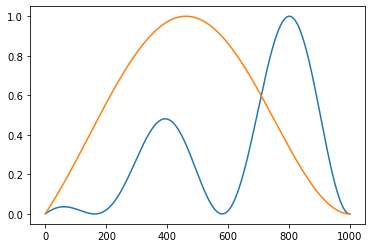

In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cosw = []
for i in range(0,1000):
    cosw.append(((-1)*((1000-i)*(np.cos(i*0.015)))/1000)-(i/1000))

#Mapping the sine wave between 0 and 1
delta = [(x - min(cosw))/(max(cosw)-min(cosw)) for x in cosw]

cosw = []
for i in range(0,1000):
    cosw.append(((-1)*((1000-i)*(np.cos(i*0.004)))/1000)-(i/1000))

#Mapping the sine wave between 0 and 1
delta2 = [(x - min(cosw))/(max(cosw)-min(cosw)) for x in cosw]

delta = delta[::-1]
delta2 = delta2[::-1]

plt.plot(delta)
plt.plot(delta2)

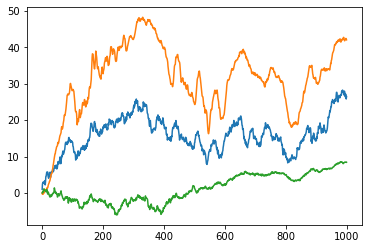

In [16]:
#Simulating Timeseries 2
dumdata01 = [0]*1000
dumdata01[0] = 1
for i in range(1,1000):
    dumdata01[i] = dumdata01[i-1] + np.random.normal(0,0.55,1)[0] + 0.03

#Simulating Timeseries 1
dumdata02 = [0]*1000
for i in range(0,1000):
    if i < 100:
        dumdata02[i] = (1-delta[i])*(dumdata02[i-1] + np.random.normal(0,0.25,1)[0]) + (delta[i])*(dumdata01[i-4] + dumdata01[i-5] ) 
    #After the first 100 time points, switching influence order
    if i >= 100:
        dumdata02[i] = (1-delta[i])*(dumdata02[i-1] + np.random.normal(0,0.25,1)[0]) + (delta[i])*(dumdata01[i-4] + dumdata01[i-5] ) 

dumdata03 = [0]*1000
for i in range(1,1000):
    if i < 500:
        dumdata03[i] = dumdata03[i-1] + np.random.normal(0,0.35,1)[0]
    if i >= 500:
        dumdata03[i] = 0.75*(500/i)*(dumdata03[i-1] + np.random.normal(0,0.25,1)[0]) + 0.25*(1-(500/i))*dumdata02[i-5] 

    
    
#holder1 = dumdata01
#holder2 = dumdata02
#dumdata01 = holder2
#dumdata02 = holder1

df = pd.DataFrame([dumdata01,dumdata02,dumdata03])

plt.plot(df.T);

In [ ]:
########################################################################################################################################
######### Duplicating the time-series, sticking a reversed version to the end for smoother process (forward and backward pass) #########
########################################################################################################################################

df2 = df.T
df2 = df2.iloc[::-1].reset_index().drop("index",axis=1)
df3 = pd.concat([df.T,df2]).reset_index().drop("index",axis=1)
df3 = df3.T
df3

In [24]:
p = 5

Yhat_test, Xhatstorage_test, Errorstorage_test, Rstorage_test, Pstorage_test = kalman_var(df3.T, p, 0.1)

In [25]:
####################################
########## KALMAN SMOOTHER #########
####################################


Xhat_to_reverse = Xhatstorage_test[1000:2000]
Xhat_reversed = Xhat_to_reverse[::-1]

Pstorage_to_reverse = Pstorage_test[1000:2000]
Pstorage_reversed = Pstorage_to_reverse[::-1]

Xhat_smooth = []

for i in range(0,1000):
    Xhat_smooth.append(
        np.dot( np.linalg.inv( np.linalg.inv(Pstorage_test[i]) + np.linalg.inv(Pstorage_reversed[i]) ) , 
          ( np.dot( np.linalg.inv(Pstorage_test[i]) , Xhatstorage_test[i]) + np.dot(np.linalg.inv( Pstorage_reversed[i] ) , Xhat_reversed[i]) ) 
          )
    )
    

C:\Users\sande\AppData\Local\Temp/ipykernel_21760/4073274277.py:64: RuntimeWarning: invalid value encountered in double_scalars
  (abs( ( temp_hold[t][j,i]*(1/Rstorage[t][j][j]) ) /


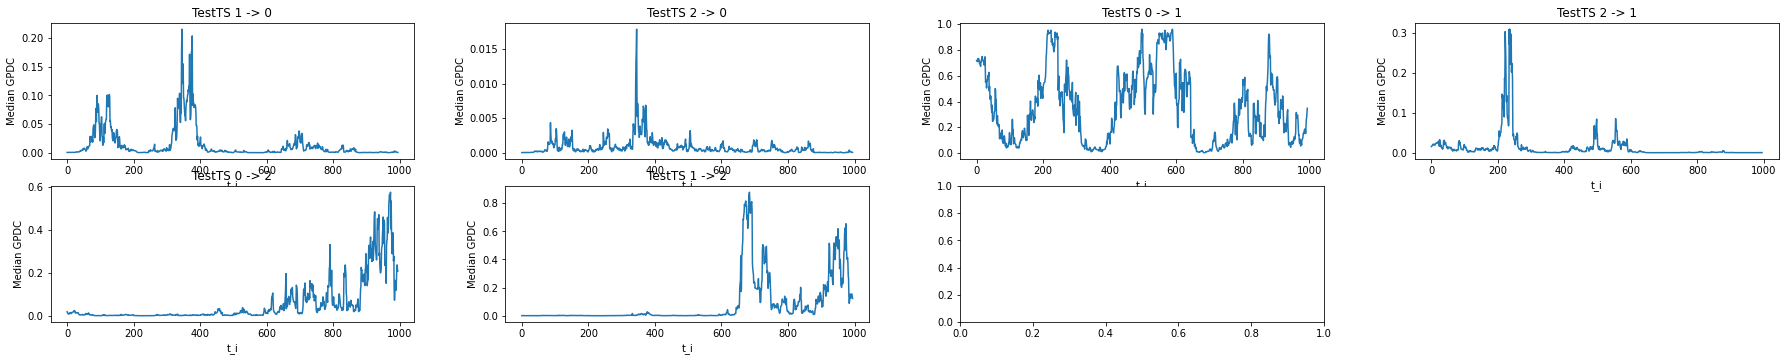

In [26]:
import numpy as np
p = 5

Yhat_test, Xhatstorage_test, Errorstorage_test, Rstorage_test, Pstorage_test = kalman_var(df2.T, p, 0.05)

f_list = [round(item,3) for item in np.arange(-0.5,0.55,0.05)]

MasterAdic_test, f_list = calcGPDC(Xhat_smooth, Rstorage_test, p, f_list, 3)

keylist = [key for key in df.index]

o=1
plt.subplot(9,4,1)
plt.subplots_adjust(left=1, bottom=4, right=5, top=9, wspace=0.25)
for key in MasterAdic_test.keys():
    if key not in ['A11',"A22","A33","A44","A55","A66"]:
        plt.plot(MasterAdic_test[key].transpose().median())
        plt.title('TestTS '+str(keylist[int(key[2])-1])+" -> "+str(keylist[int(key[1])-1]))
        plt.ylabel('Median GPDC')
        plt.xlabel("t_i")
        o=o+1
        plt.subplot(9,4,o)

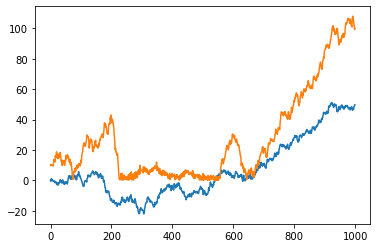

In [289]:
#Attempting simultaneous time series generation


ts_1 = list(np.random.normal(0.5,0.55,10))
ts_2 = list(np.random.normal(10,0.55,10))

i=9
while len(ts_1) < 1000:
    ts_1.append( ts_1[i] + np.random.normal(0.05,0.95,1)[0] )
    i=i+1
i=9
while len(ts_2) < 1000:
    ts_2.append( abs((1-delta[i])*(ts_2[i] + np.random.normal(0.5,1.55,1)[0]) + (delta[i])*(ts_1[i-2]+ts_1[i-3] + np.random.normal(-1.75,0.55,1)[0])) )
    i=i+1

plt.plot(ts_1)
plt.plot(ts_2)

In [290]:
data_to_filter = pd.DataFrame([ts_1,ts_2]).T
data_to_filter.columns = ["ts_1","ts_2"]
data_to_filter = data_to_filter.T
data_to_filter

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
ts_1,-0.012988,-0.557481,1.020953,0.172204,0.914384,0.161621,0.456258,-0.361839,-0.441864,-0.640688,...,46.556348,46.089535,47.106655,46.955437,46.686452,47.024606,48.556067,48.647774,49.606402,49.72086
ts_2,10.018199,10.052594,10.503088,9.874957,9.974140,9.861352,9.698338,9.675511,9.405567,9.958310,...,104.992585,107.082427,107.942192,106.140396,105.470743,103.876812,102.635350,100.762206,99.283717,99.91431


In [318]:
p = 4

Yhat_test, Xhatstorage_test, Errorstorage_test, Rstorage_test, Pstorage_test = kalman_var(data_to_filter, p, 0.5)

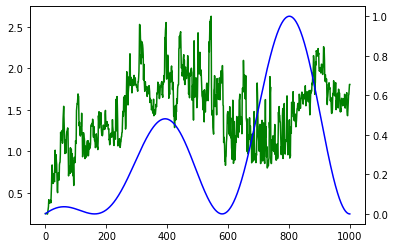

In [319]:
ndc_list = []
for i in range(len(Xhatstorage_test)):
    ndc_list.append( norm_dc(Xhatstorage_test[i], 0, 1, 3, 2)[1] )

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ndc_list, 'g-')
ax2.plot(delta, 'b-')


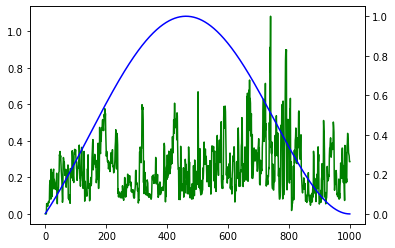

In [323]:
ndc_list = []
for i in range(len(Xhatstorage_test)):
    ndc_list.append( norm_dc(Xhatstorage_test[i], 1, 0, 3, 2)[1] )

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ndc_list, 'g-')
ax2.plot(delta2, 'b-')
